In [3]:
# This file is a modified version of the original:
# https://www.kaggle.com/mark4h/jowilder-2nd-place-solution-3-train-model

In [4]:
import json
import lightgbm as lgb
import matplotlib.pyplot as plt
import numba
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

In [8]:
PREPROCESSED_DIR = 'input/'
FEATURE_GEN_CODE_DIR = 'modules/'
FEATURES_DIR = ''

In [9]:
%%time
train_labels_df = pd.read_pickle(PREPROCESSED_DIR + 'preprocessed_train_labels_df.pkl')

CPU times: user 56.8 ms, sys: 28.4 ms, total: 85.3 ms
Wall time: 84.8 ms


In [11]:
X_session_id = np.load(FEATURES_DIR + 'X_session_id.npy')
X_out_level_group = np.load(FEATURES_DIR + 'X_out_level_group.npy')
X_out_question_number = np.load(FEATURES_DIR + 'X_out_question_number.npy')
X_out = np.load(FEATURES_DIR + 'X_out.npy')

with open(FEATURE_GEN_CODE_DIR + "FEATURE_NAMES.json", "r") as f:
    FEATURE_NAMES = json.loads(f.read())

In [12]:
assert np.all(train_labels_df['session_id_base'].values.astype(int) == X_session_id)
assert np.all((train_labels_df['session_id_question'].values - 1) == X_out_question_number)

target = train_labels_df['correct'].values

In [13]:
feature_names_to_drop = [
    'level_group',
    'session_start_time',
    'session_end_time',
    'session_duration',
    'name_prev_4_count',
    'name_next_5_count',
    'is_level_group_0',
    'is_level_group_1',
    'is_level_group_2',
    'event_name_observation_click_3_count',
    'event_name_checkpoint_9_count',
    'is_question_18',
    'last_event_name',
    'last_name',
    'building_capitol_2_count',
    'building_kohlcenter_count',
    'building_wildlife_count',
    'room_basement_count',
    'room_cage_count',
    'room_center_count',
    'room_closet_count',
    'room_collection_flag_count',
    'room_halloffame_count',
    'building_capitol_2_proportion_of_events',
    'building_flaghouse_proportion_of_events',
    'building_kohlcenter_proportion_of_events',
    'building_wildlife_proportion_of_events',
    'level_with_most_events',
    'level_with_least_events',
    'building_nunqiue',
    'room_nunqiue',
    'elapsed_time_in_increasing_order',
    'session_index_diff_max',
    'building_capitol_0_visits_count',
    'building_capitol_1_visits_count',
    'building_capitol_2_visits_count',
    'building_drycleaner_visits_count',
    'building_flaghouse_visits_count',
    'building_historicalsociety_visits_count',
    'building_humanecology_visits_count',
    'building_kohlcenter_visits_count',
    'building_library_visits_count',
    'building_wildlife_visits_count',
    'building_visits_nunqiue',
    'room_basement_visits_count',
    'room_cage_visits_count',
    'room_center_visits_count',
    'room_closet_visits_count',
    'room_collection_visits_count',
    'room_collection_flag_visits_count',
    'room_entry_visits_count',
    'room_hall_visits_count',
    'room_halloffame_visits_count',
    'room_microfiche_visits_count',
    'room_visits_nunqiue',
    'LG0_fqid_chap1_finale_last_occurrence_duration_from_end',
    'fqids_block_0_count',
    'fqids_block_1_count',
    'fqids_block_badge_count',
    'fqids_block_badge_2_count',
    'fqids_block_magnify_count',
    'fqids_block_nelson_count',
    'fqids_block_tocollection_count',
    'fqids_block_tomap1_count',
    'fqids_block_tomap2_count',
    'fqids_boss_count',
    'fqids_businesscards_card_0_next_count',
    'fqids_ch3start_count',
    'fqids_chap1_finale_c_count',
    'fqids_chap2_finale_c_count',
    'fqids_chap4_finale_c_count',
    'fqids_coffee_count',
    'fqids_colorbook_count',
    'fqids_confrontation_count',
    'fqids_crane_ranger_count',
    'fqids_cs_count',
    'fqids_directory_count',
    'fqids_directory_closeup_archivist_count',
    'fqids_door_block_clean_count',
    'fqids_doorblock_count',
    'fqids_expert_count',
    'fqids_fox_count',
    'fqids_glasses_count',
    'fqids_groupconvo_count',
    'fqids_groupconvo_flag_count',
    'fqids_intro_count',
    'fqids_janitor_count',
    'fqids_journals_pic_2_bingo_count',
    'fqids_journals_flag_count',
    'fqids_journals_flag_hub_topics_count',
    'fqids_journals_flag_hub_topics_old_count',
    'fqids_journals_flag_pic_0_bingo_count',
    'fqids_journals_flag_pic_0_old_next_count',
    'fqids_journals_flag_pic_1_bingo_count',
    'fqids_journals_flag_pic_1_old_next_count',
    'fqids_journals_flag_pic_2_bingo_count',
    'fqids_journals_flag_pic_2_old_next_count',
    'fqids_key_count',
    'fqids_lockeddoor_count',
    'fqids_logbook_page_bingo_count',
    'fqids_magnify_count',
    'fqids_need_glasses_count',
    'fqids_notebook_count',
    'fqids_outtolunch_count',
    'fqids_photo_count',
    'fqids_plaque_face_date_count',
    'fqids_reader_paper0_prev_count',
    'fqids_reader_paper1_prev_count',
    'fqids_reader_paper2_next_count',
    'fqids_reader_flag_count',
    'fqids_reader_flag_paper0_next_count',
    'fqids_reader_flag_paper0_prev_count',
    'fqids_reader_flag_paper1_next_count',
    'fqids_reader_flag_paper1_prev_count',
    'fqids_reader_flag_paper2_bingo_count',
    'fqids_reader_flag_paper2_next_count',
    'fqids_reader_flag_paper2_prev_count',
    'fqids_remove_cup_count',
    'fqids_report_count',
    'fqids_retirement_letter_count',
    'fqids_savedteddy_count',
    'fqids_seescratches_count',
    'fqids_teddy_count',
    'fqids_tocage_count',
    'fqids_tocloset_count',
    'fqids_tocloset_dirty_count',
    'fqids_tocollection_count',
    'fqids_tocollectionflag_count',
    'fqids_tofrontdesk_count',
    'fqids_togrampa_count',
    'fqids_tohallway_count',
    'fqids_tomap_count',
    'fqids_tomicrofiche_count',
    'fqids_tracks_hub_deer_count',
    'fqids_trigger_coffee_count',
    'fqids_trigger_scarf_count',
    'fqids_tunic_count',
    'fqids_tunic_capitol_0_count',
    'fqids_tunic_capitol_1_count',
    'fqids_tunic_capitol_2_count',
    'fqids_tunic_drycleaner_count',
    'fqids_tunic_flaghouse_count',
    'fqids_tunic_historicalsociety_count',
    'fqids_tunic_hub_slip_count',
    'fqids_tunic_humanecology_count',
    'fqids_tunic_library_count',
    'fqids_tunic_wildlife_count',
    'fqids_unlockdoor_count',
    'fqids_wells_count',
    'fqids_wellsbadge_count',
    'fqids_what_happened_count',
    'building_capitol_0_first_occurrence_num_event_from_start',
    'building_capitol_0_first_occurrence_duration_from_start',
    'building_capitol_1_last_occurrence_duration_from_end',
    'building_capitol_2_last_occurrence_num_event_from_end',
    'building_capitol_2_first_occurrence_time',
    'building_capitol_2_last_occurrence_time',
    'building_capitol_2_first_occurrence_duration_from_start',
    'building_capitol_2_last_occurrence_duration_from_start',
    'building_capitol_2_last_occurrence_duration_from_end',
    'building_drycleaner_last_occurrence_time',
    'building_flaghouse_first_occurrence_num_event_from_start',
    'building_flaghouse_last_occurrence_num_event_from_start',
    'building_flaghouse_last_occurrence_num_event_from_end',
    'building_flaghouse_first_occurrence_time',
    'building_flaghouse_last_occurrence_time',
    'building_flaghouse_first_occurrence_duration_from_start',
    'building_flaghouse_last_occurrence_duration_from_start',
    'building_flaghouse_last_occurrence_duration_from_end',
    'building_historicalsociety_first_occurrence_num_event_from_start',
    'building_historicalsociety_last_occurrence_num_event_from_start',
    'building_historicalsociety_first_occurrence_time',
    'building_historicalsociety_last_occurrence_time',
    'building_historicalsociety_last_occurrence_duration_from_start',
    'building_historicalsociety_first_occurrence_duration_from_end',
    'building_kohlcenter_first_occurrence_num_event_from_end',
    'building_kohlcenter_last_occurrence_num_event_from_end',
    'building_kohlcenter_first_occurrence_time',
    'building_kohlcenter_last_occurrence_time',
    'building_kohlcenter_first_occurrence_duration_from_start',
    'building_kohlcenter_last_occurrence_duration_from_start',
    'building_library_last_occurrence_num_event_from_start',
    'building_library_first_occurrence_time',
    'building_library_last_occurrence_time',
    'building_library_last_occurrence_duration_from_start',
    'building_wildlife_first_occurrence_num_event_from_start',
    'building_wildlife_last_occurrence_num_event_from_start',
    'building_wildlife_first_occurrence_time',
    'building_wildlife_last_occurrence_time',
    'building_wildlife_first_occurrence_duration_from_start',
    'building_wildlife_last_occurrence_duration_from_start',
    'building_wildlife_first_occurrence_duration_from_end',
    'building_wildlife_last_occurrence_duration_from_end',
    'room_basement_first_occurrence_time',
    'room_basement_first_occurrence_duration_from_end',
    'room_cage_first_occurrence_num_event_from_start',
    'room_cage_first_occurrence_duration_from_start',
    'room_cage_last_occurrence_duration_from_start',
    'room_cage_first_occurrence_duration_from_end',
    'room_cage_last_occurrence_duration_from_end',
    'room_center_first_occurrence_num_event_from_start',
    'room_center_last_occurrence_num_event_from_start',
    'room_center_first_occurrence_num_event_from_end',
    'room_center_last_occurrence_num_event_from_end',
    'room_center_first_occurrence_time',
    'room_center_last_occurrence_time',
    'room_center_first_occurrence_duration_from_start',
    'room_center_last_occurrence_duration_from_start',
    'room_center_first_occurrence_duration_from_end',
    'room_center_last_occurrence_duration_from_end',
    'room_closet_first_occurrence_num_event_from_start',
    'room_closet_last_occurrence_num_event_from_start',
    'room_closet_first_occurrence_num_event_from_end',
    'room_closet_first_occurrence_time',
    'room_closet_last_occurrence_time',
    'room_closet_first_occurrence_duration_from_start',
    'room_closet_last_occurrence_duration_from_start',
    'room_closet_first_occurrence_duration_from_end',
    'room_closet_last_occurrence_duration_from_end',
    'room_collection_flag_first_occurrence_num_event_from_start',
    'room_collection_flag_first_occurrence_time',
    'room_collection_flag_last_occurrence_time',
    'room_collection_flag_first_occurrence_duration_from_start',
    'room_collection_flag_last_occurrence_duration_from_start',
    'room_collection_flag_first_occurrence_duration_from_end',
    'room_collection_flag_last_occurrence_duration_from_end',
    'room_entry_last_occurrence_num_event_from_start',
    'room_entry_last_occurrence_num_event_from_end',
    'room_entry_first_occurrence_time',
    'room_entry_last_occurrence_time',
    'room_entry_last_occurrence_duration_from_start',
    'room_entry_first_occurrence_duration_from_end',
    'room_frontdesk_first_occurrence_time',
    'room_frontdesk_last_occurrence_time',
    'room_frontdesk_last_occurrence_duration_from_start',
    'room_hall_first_occurrence_num_event_from_start',
    'room_hall_first_occurrence_num_event_from_end',
    'room_hall_last_occurrence_num_event_from_end',
    'room_hall_first_occurrence_time',
    'room_hall_last_occurrence_time',
    'room_hall_first_occurrence_duration_from_start',
    'room_hall_last_occurrence_duration_from_start',
    'room_hall_last_occurrence_duration_from_end',
    'room_halloffame_first_occurrence_num_event_from_start',
    'room_halloffame_last_occurrence_num_event_from_start',
    'room_halloffame_first_occurrence_num_event_from_end',
    'room_halloffame_last_occurrence_num_event_from_end',
    'room_halloffame_first_occurrence_time',
    'room_halloffame_last_occurrence_time',
    'room_halloffame_first_occurrence_duration_from_start',
    'room_halloffame_last_occurrence_duration_from_start',
    'room_microfiche_last_occurrence_num_event_from_start',
    'room_microfiche_first_occurrence_time',
    'room_microfiche_last_occurrence_time',
    'room_microfiche_last_occurrence_duration_from_start',
    'room_stacks_last_occurrence_time',
    'room_stacks_last_occurrence_duration_from_start',
    'fqid_chap1_finale_first_occurrence_num_event_from_start',
    'fqid_chap1_finale_last_occurrence_num_event_from_start',
    'fqid_chap1_finale_first_occurrence_num_event_from_end',
    'fqid_chap1_finale_last_occurrence_num_event_from_end',
    'fqid_chap1_finale_first_occurrence_time',
    'fqid_chap1_finale_last_occurrence_time',
    'fqid_chap1_finale_first_occurrence_duration_from_start',
    'fqid_chap1_finale_last_occurrence_duration_from_start',
    'fqid_directory_closeup_archivist_last_occurrence_num_event_from_end',
    'fqid_directory_closeup_archivist_first_occurrence_duration_from_end',
    'fqid_directory_closeup_archivist_last_occurrence_duration_from_end',
    'fqid_journals_pic_0_next_first_occurrence_time',
    'fqid_journals_pic_0_next_last_occurrence_time',
    'fqid_journals_pic_0_next_first_occurrence_duration_from_start',
    'fqid_journals_pic_0_next_last_occurrence_duration_from_start',
    'fqid_tocloset_dirty_first_occurrence_time',
    'fqid_tomap_last_occurrence_time',
    'fqid_tomap_last_occurrence_duration_from_start',
    'fqid_tomicrofiche_first_occurrence_num_event_from_start',
    'fqid_tomicrofiche_last_occurrence_num_event_from_start',
    'fqid_tomicrofiche_first_occurrence_time',
    'fqid_tomicrofiche_last_occurrence_time',
    'fqid_tomicrofiche_first_occurrence_duration_from_start',
    'fqid_tomicrofiche_last_occurrence_duration_from_start',
    'level_0_event_count',
    'level_1_event_count',
    'level_2_event_count',
    'level_4_event_count',
    'level_5_event_count',
    'level_13_event_count',
    'level_14_event_count',
    'level_15_event_count',
    'level_16_event_count',
    'level_17_event_count',
    'level_19_event_count',
    'level_21_event_count',
    'level_22_event_count',
]
    
feature_names = [f for f in FEATURE_NAMES if f not in feature_names_to_drop]
feature_mask = np.array([f not in feature_names_to_drop for f in FEATURE_NAMES])

print(len(feature_names), "of", len(FEATURE_NAMES))

# 1296 of 1590

1296 of 1590


In [14]:
len(feature_names_to_drop)

294

In [15]:
np.save('FEATURE_MASK.npy', feature_mask)

In [18]:
params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'seed': 115,
    'verbose': 1, # -1
    'n_estimators': 1500, #1127
    'learning_rate': 0.01737626476323869,
    'lambda_l2': 0.00036464120938417137,
    'lambda_l1': 0.0005242828251271847,
    'min_data_in_leaf': 721,
    'feature_fraction': 0.17246267000882093,
    'max_depth': 16,
    'subsample': 0.12687152291829285,
    'num_leaves': 218,
}

In [19]:
%%time

iteration = 0
fold = 0

trn = lgb.Dataset(
    X_out[:, feature_mask],
    target,
    feature_name=feature_names,
)

with warnings.catch_warnings():
    warnings.simplefilter('ignore', UserWarning)
    model = lgb.train(
        params,
        trn,
        valid_sets=[trn],
        valid_names=['trn'],
        #verbose_eval=100,
    )
    
model.save_model(f"model_{iteration}_{fold}.txt")

importances_df = pd.DataFrame()
importances_df['feature'] = feature_names
importances_df['gain'] = model.feature_importance(importance_type='gain')
importances_df['normalised_gain'] = np.array(model.feature_importance(importance_type='gain'))/np.sum(model.feature_importance(importance_type='gain'))
importances_df['fold'] = fold
importances_df['iteration'] = iteration

[LightGBM] [Info] Number of positive: 299271, number of negative: 124845
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 2.318868 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 294695
[LightGBM] [Info] Number of data points in the train set: 424116, number of used features: 1295
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.705635 -> initscore=0.874277
[LightGBM] [Info] Start training from score 0.874277
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [20]:
def save_importances(
    importances_, 
    filename='importances.png', 
    print_results=False, 
    figsize=(8, 6),
    max_features=None,
    use_log_scale=False,
    title=None,
):
    mean_gain = importances_[['gain', 'feature']].groupby('feature').mean()
    if print_results:
        from IPython.core.display import HTML
        display(HTML(mean_gain.sort_values('gain').to_html()))
    importances_['mean_gain'] = importances_['feature'].map(mean_gain['gain'])
    plt.figure(figsize=figsize)
    
    d = importances_.sort_values('mean_gain', ascending=False)
    
    if max_features is not None:
        top_features = mean_gain.sort_values('gain').index.values[-max_features:]
        d = d[d['feature'].isin(top_features)]
    
    p = sns.barplot(x='gain', y='feature', data=d)
    if title is not None:
        p.set_title(title)
    else:
        p.set_title(filename)
    plt.tight_layout()
    if use_log_scale:
        plt.xscale("log")
        
    if filename is not None:
        plt.savefig(filename)
    
        mean_gain.to_pickle(filename[:-4] + "_means" + '.pkl')
    
    return mean_gain.sort_values('gain')

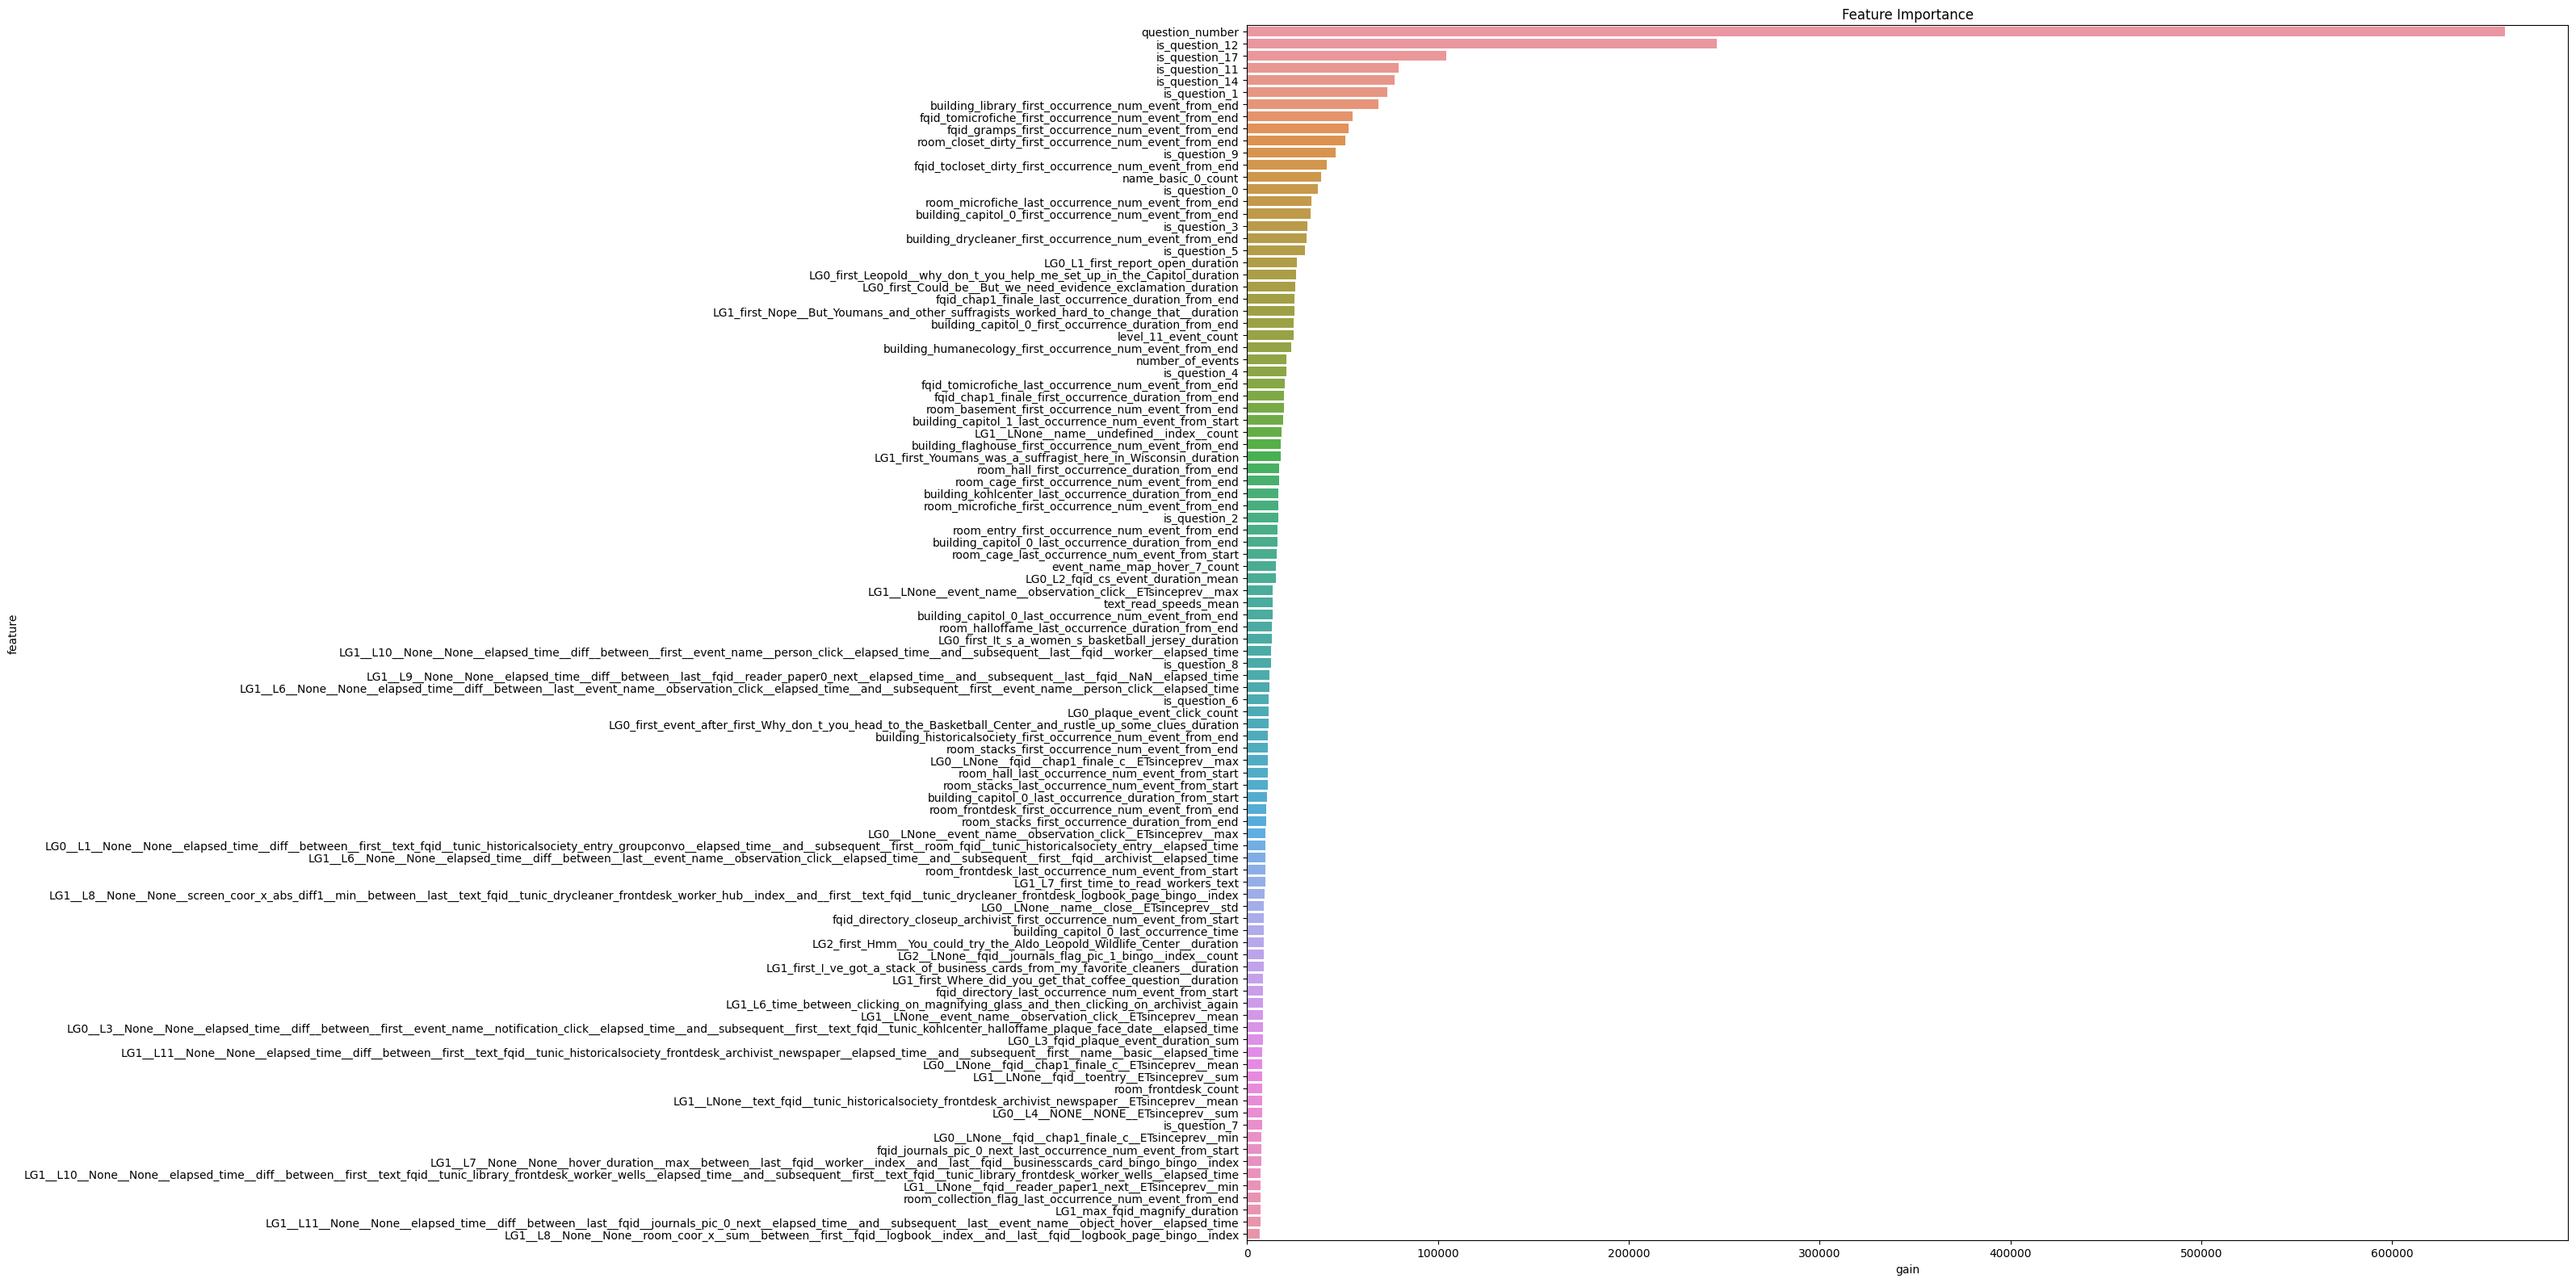

In [21]:
mean_gains = save_importances(
    importances_df,
    use_log_scale=False,
    figsize=(32, 16),
    max_features=100,
    filename=None,
    title="Feature Importance",
)

In [24]:
mean_gains.sort_values('gain', ascending=False).head(30)

,gain
feature,
question_number,659114.392856
is_question_12,246136.942502
is_question_17,104230.749775
is_question_11,79354.851125
is_question_14,77315.318939
is_question_1,73335.254447
building_library_first_occurrence_num_event_from_end,68919.836849
fqid_tomicrofiche_first_occurrence_num_event_from_end,55307.226360
fqid_gramps_first_occurrence_num_event_from_end,53090.465362


In [23]:
mean_gains.sort_values('gain', ascending=False).to_csv('feature_importance.csv')

In [14]:
THRESHOLD = 0.63

with open("MODEL_INFO.json", "w") as f:
    f.write(json.dumps({
        'THRESHOLD': THRESHOLD,
    }))

In [15]:
!ls -lh

total 24M
-rw-r--r-- 1 root root 1.7K Jul  4 10:03 FEATURE_MASK.npy
-rw-r--r-- 1 root root   19 Jul  4 10:21 MODEL_INFO.json
---------- 1 root root 804K Jul  4 10:21 __notebook__.ipynb
-rw-r--r-- 1 root root 150K Jul  4 10:21 feature_importance.csv
-rw-r--r-- 1 root root  23M Jul  4 10:21 model_0_0.txt
